# Matched Filter Pipeline Demo

Run the PRISMA or EnMAP methane matched-filter pipeline end-to-end and visualise the key outputs (RGB, concentration, and instrument-noise uncertainty).

In [1]:
import os
import sys
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal

NOTEBOOK_ROOT = Path.cwd().resolve()
REPO_ROOT = NOTEBOOK_ROOT
while not (REPO_ROOT / 'scripts').exists() and REPO_ROOT.parent != REPO_ROOT:
    REPO_ROOT = REPO_ROOT.parent
if not (REPO_ROOT / 'scripts').exists():
    raise RuntimeError('Could not locate repository root containing scripts directory.')

os.environ.setdefault('PYTHONPATH', str(REPO_ROOT))
if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))

print(f'Notebook root: {NOTEBOOK_ROOT}')
print(f'Repository root: {REPO_ROOT}')

Notebook root: /mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/notebooks
Repository root: /mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas


In [ ]:
# Configure which sensor to run. Set SENSOR to 'prisma' or 'enmap'.
SENSOR = 'prisma'

PRISMA_CONFIG = {
    'l1': Path('/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/test_data/prisma/Ekizak_Turkmenistan_20220912/20220912072502_20220912072506/PRS_L1_STD_OFFL_20220912072502_20220912072506_0001.zip'),
    'l2c': Path('/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/test_data/prisma/Ekizak_Turkmenistan_20220912/20220912072502_20220912072506/PRS_L2C_STD_20220912072502_20220912072506_0001.zip'),
    'dem': Path('/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/DEM_1Km/srtm30plus_v11_land.nc'),
    'lut': Path('/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/LUTs/CH4_lut.hdf5'),
    'snr_reference': REPO_ROOT / 'notebooks' / 'outputs' / 'prisma' / '20200401085313' / 'snr_reference_columnwise.npz',
    'output_dir': NOTEBOOK_ROOT / 'outputs' / 'pipeline_demo' / 'prisma',
    'min_wavelength': 2100.0,
    'max_wavelength': 2450.0,
    'k': 1,
}

ENMAP_CONFIG = {
    'vnir': Path('/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/test_data/enmap/Turkmenistan_20221002/20221002T074828/L1B_20221002T074828Z_001_V010501_20241110T222720Z/ENMAP01-____L1B-DT0000004147_20221002T074828Z_001_V010501_20241110T222720Z-SPECTRAL_IMAGE_VNIR.TIF'),
    'swir': Path('/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/test_data/enmap/Turkmenistan_20221002/20221002T074828/L1B_20221002T074828Z_001_V010501_20241110T222720Z/ENMAP01-____L1B-DT0000004147_20221002T074828Z_001_V010501_20241110T222720Z-SPECTRAL_IMAGE_SWIR.TIF'),
    'metadata': Path('/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/test_data/enmap/Turkmenistan_20221002/20221002T074828/L1B_20221002T074828Z_001_V010501_20241110T222720Z/ENMAP01-____L1B-DT0000004147_20221002T074828Z_001_V010501_20241110T222720Z-METADATA.XML'),
    'lut': Path('/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/LUTs/CH4_lut.hdf5'),
    'snr_reference': REPO_ROOT / 'notebooks' / 'outputs' / 'enmap' / 'L1B-DT0000001584_20220712T104302Z_001_V010502_20251017T093724Z' / 'snr_reference_columnwise.npz',
    'output_dir': NOTEBOOK_ROOT / 'outputs' / 'pipeline_demo' / 'enmap',
    'min_wavelength': 2100.0,
    'max_wavelength': 2450.0,
    'k': 1,
}

CONFIG = PRISMA_CONFIG if SENSOR.lower() == 'prisma' else ENMAP_CONFIG
CONFIG['output_dir'].mkdir(parents=True, exist_ok=True)
CONFIG


{'vnir': PosixPath('/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/test_data/enmap/Turkmenistan_20221002/20221002T074828/L1B_20221002T074828Z_001_V010501_20241110T222720Z/ENMAP01-____L1B-DT0000004147_20221002T074828Z_001_V010501_20241110T222720Z-SPECTRAL_IMAGE_VNIR.TIF'),
 'swir': PosixPath('/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/test_data/enmap/Turkmenistan_20221002/20221002T074828/L1B_20221002T074828Z_001_V010501_20241110T222720Z/ENMAP01-____L1B-DT0000004147_20221002T074828Z_001_V010501_20241110T222720Z-SPECTRAL_IMAGE_SWIR.TIF'),
 'metadata': PosixPath('/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/test_data/enmap/Turkmenistan_20221002/20221002T074828/L1B_20221002T074828Z_001_V010501_20241110T222720Z/ENMAP01-____L1B-DT0000004147_20221002T074828Z_001_V010501_20241110T222720Z-METADATA.XML'),
 'lut': PosixPath('/mnt/d/Lavoro/Assegno_Ricerca_Sapi

In [3]:
import importlib

def run_pipeline(sensor: str, cfg: dict):
    sensor = sensor.lower()
    if sensor == 'prisma':
        from scripts.pipelines import prisma_pipeline as _prisma_pipeline
        prisma_pipeline = importlib.reload(_prisma_pipeline)
        prisma_pipeline.ch4_detection(
            L1_file=str(cfg['l1']),
            L2C_file=str(cfg['l2c']),
            dem_file=str(cfg['dem']),
            lut_file=str(cfg['lut']),
            output_dir=str(cfg['output_dir']),
            min_wavelength=cfg['min_wavelength'],
            max_wavelength=cfg['max_wavelength'],
            k=cfg['k'],
            save_rads=False,
            snr_reference_path=str(cfg['snr_reference']),
        )
    elif sensor == 'enmap':
        from scripts.pipelines import enmap_pipeline as _enmap_pipeline
        enmap_pipeline = importlib.reload(_enmap_pipeline)
        enmap_pipeline.ch4_detection_enmap(
            vnir_file=str(cfg['vnir']),
            swir_file=str(cfg['swir']),
            metadata_file=str(cfg['metadata']),
            lut_file=str(cfg['lut']),
            output_dir=str(cfg['output_dir']),
            k=cfg['k'],
            min_wavelength=cfg['min_wavelength'],
            max_wavelength=cfg['max_wavelength'],
            snr_reference_path=str(cfg['snr_reference']),
        )
    else:
        raise ValueError(f'Unsupported sensor: {sensor}')

run_pipeline(SENSOR, CONFIG)
print('Pipeline run complete.')


Sun Zenith Angle (degrees): 43.0
Mean Water Vapor (g/cm^2): 1.605
Mean Ground Elevation (m): -15.3223
Report di elaborazione EnMAP generato in: /mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/notebooks/outputs/pipeline_demo/enmap/processing_report.txt
Pipeline run complete.


RGB: /mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/notebooks/outputs/pipeline_demo/enmap/L1B_DT0000004147_001_20221002T074828Z_20221002T074833Z_RGB.tif
Concentration: /mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/notebooks/outputs/pipeline_demo/enmap/L1B_DT0000004147_001_20221002T074828Z_20221002T074833Z_MF.tif
Uncertainty: /mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/notebooks/outputs/pipeline_demo/enmap/L1B_DT0000004147_001_20221002T074828Z_20221002T074833Z_MF_uncertainty.tif


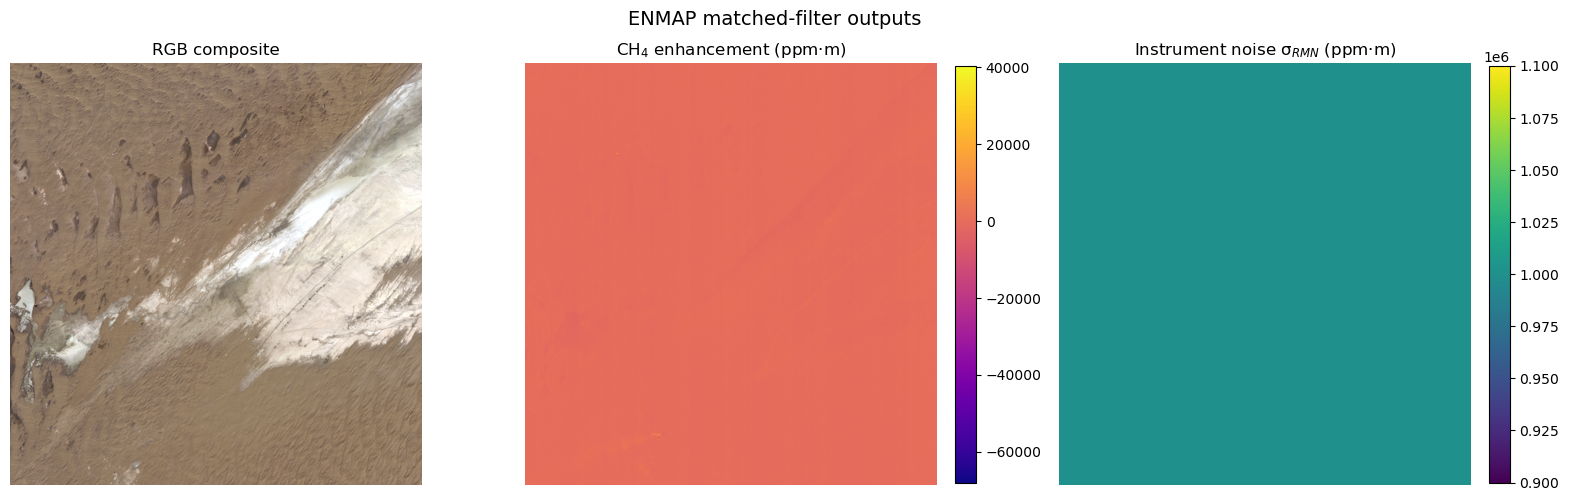

In [4]:
def _find_output(pattern: str):
    matches = sorted(CONFIG['output_dir'].glob(pattern))
    if not matches:
        raise FileNotFoundError(f"No files matching {pattern} found in {CONFIG['output_dir']}")
    return matches[-1]

def _read_raster(path: Path):
    ds = gdal.Open(str(path))
    if ds is None:
        raise RuntimeError(f'Failed to open raster: {path}')
    arr = ds.ReadAsArray().astype(np.float32)
    ds = None
    return arr

rgb_pattern = '*_rgb.tif' if SENSOR.lower() == 'prisma' else '*_RGB.tif'
conc_pattern = '*_MF_concentration.tif' if SENSOR.lower() == 'prisma' else '*_MF.tif'

rgb_path = _find_output(rgb_pattern)
conc_path = _find_output(conc_pattern)
unc_path = _find_output('*_MF_uncertainty.tif')

print('RGB:', rgb_path)
print('Concentration:', conc_path)
print('Uncertainty:', unc_path)

rgb = _read_raster(rgb_path)
concentration = _read_raster(conc_path)
uncertainty = _read_raster(unc_path)

if rgb.ndim == 3:
    rgb_img = np.transpose(rgb, (1, 2, 0))
else:
    rgb_img = rgb

def _normalize_rgb(arr: np.ndarray) -> np.ndarray:
    high = np.quantile(arr, 0.995, axis=(0, 1), keepdims=True)
    high = np.clip(high, 1e-3, None)
    arr = np.clip(arr, 0, high)
    arr = arr / high
    return np.clip(arr, 0, 1)

rgb_disp = _normalize_rgb(rgb_img.astype(np.float32))

fig, axes = plt.subplots(1, 3, figsize=(16, 5))
axes[0].imshow(rgb_disp)
axes[0].set_title('RGB composite')
axes[0].axis('off')

im1 = axes[1].imshow(concentration, cmap='plasma')
axes[1].set_title('CH$_4$ enhancement (ppm·m)')
plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

im2 = axes[2].imshow(uncertainty, cmap='viridis')
axes[2].set_title('Instrument noise σ$_{RMN}$ (ppm·m)')
plt.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)

for ax in axes[1:]:
    ax.axis('off')

fig.suptitle(f"{SENSOR.upper()} matched-filter outputs", fontsize=14)
plt.tight_layout()
plt.show()

In [5]:
import numpy as np
ref = np.load(REPO_ROOT / 'notebooks' / 'outputs' / 'prisma' / '20200401085313' / 'snr_reference_columnwise.npz')
print(np.nanmin(ref["snr"]), np.nanpercentile(ref["snr"], [1, 50, 99]))
print(np.isnan(ref["snr"]).sum(), (ref["snr"] <hape)= 0).sum())
print(ref["band_nm"].min(), ref["band_nm"].max(), ref["band_nm"].s)

SyntaxError: unmatched ')' (3360764217.py, line 4)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

ref_path = Path("/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/notebooks/outputs/prisma/20200401085313/snr_reference_columnwise.npz")
with np.load(ref_path, allow_pickle=False) as ref:
    wl = ref["band_nm"]
    mu = ref["mean_radiance"]      # shape: (bands, columns)
    snr = ref["snr"]               # shape: (bands, columns)

print("Bands:", wl.size, "range:", wl.min(), "→", wl.max())
print("SNR min/median/max:", np.nanmin(snr), np.nanmedian(snr), np.nanmax(snr))
print("NaNs:", np.isnan(snr).sum(), "values < 1:", (snr < 1).sum())

# Column-wise overlay
plt.figure(figsize=(10, 5))
plt.plot(wl, snr, alpha=0.2)
plt.plot(wl, np.nanmedian(snr, axis=1), color="k", lw=2, label="Median across columns")
plt.xlabel("Wavelength (nm)")
plt.ylabel("SNR")
plt.title("Columnwise reference SNR")
plt.grid(alpha=0.3)
plt.legend()
plt.show()

# Radiance check (should look smooth and positive)
plt.figure(figsize=(10, 5))
plt.plot(wl, mu, alpha=0.2)
plt.plot(wl, np.nanmedian(mu, axis=1), color="k", lw=2)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Mean radiance (µW cm$^{-2}$ sr$^{-1}$ nm$^{-1}$)")
plt.title("Reference radiance profiles")
plt.grid(alpha=0.3)
plt.show()

# Inspect any bands with low/zero SNR
bad_bands = np.where(np.nanmedian(snr, axis=1) < 5)[0]
print("Bands with SNR < 5:", bad_bands, wl[bad_bands])